In [1]:
import h5py
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
import copy

from tqdm import tqdm
import pandas as pd


In [50]:
def drop_connections_until_split(adj_matrix, remove_type='lowest', directed=False):
    """
    Removes connections from the adjacency matrix based on the specified remove_type
    ('lowest' or 'highest' absolute values) until the graph splits into multiple
    connected components.

    Parameters:
    - adj_matrix (np.ndarray): Square adjacency matrix.
    - remove_type (str): 'lowest' to remove weakest connections first,
                         'highest' to remove strongest connections first.
    - directed (bool): Whether the graph is directed.

    Returns:
    - np.ndarray: Modified adjacency matrix with certain connections set to zero.
    """
    # Validate remove_type
    if remove_type not in ['lowest', 'highest']:
        raise ValueError("remove_type must be either 'lowest' or 'highest'.")

    # Ensure the adjacency matrix is a NumPy array
    abs_matrix = np.abs(np.array(copy.deepcopy(adj_matrix)))
    
    # Create a NetworkX graph from the adjacency matrix
    if directed:
        G = nx.from_numpy_array(abs_matrix, create_using=nx.DiGraph)
    else:
        G = nx.from_numpy_array(abs_matrix)
    
    # Define the connectivity check based on graph type
    if directed:
        connectivity_func = nx.is_strongly_connected
    else:
        connectivity_func = nx.is_connected

    # If the graph is already disconnected, return as is
    if not connectivity_func(G):
        print("The input graph is already disconnected.")
        return adj_matrix
    
    # Get all edges with their absolute weights
    edges = list(G.edges(data=True))
    # Sort edges based on absolute weight
    if remove_type == 'lowest':
        edges_sorted = sorted(edges, key=lambda x: abs(x[2]['weight']))
    else:  # remove_type == 'highest'
        edges_sorted = sorted(edges, key=lambda x: abs(x[2]['weight']), reverse=True)
    
    print(edges_sorted)

    # Iterate through sorted edges and remove them one by one
    for u, v, data in edges_sorted:
        # Remove the edge
        G.remove_edge(u, v)
        
        # Check if the graph is still connected
        still_connected = connectivity_func(G)
        
        if not still_connected:
            # If removing this edge disconnects the graph, add it back and stop
            G.add_edge(u, v, weight=data['weight'])
            print(f"Stopping removal. Removing edge ({u}, {v}) would disconnect the graph.")
            break
        else:
            # If still connected, set the corresponding entry in adj_matrix to zero
            adj_matrix[u, v] = 0
            if not directed:
                adj_matrix[v, u] = 0  # For undirected graphs
    
    return adj_matrix


In [36]:
path = "f:\\git\\eeg_prep\\processed_files\\001_000500_000500.hdf5"
path = "/media/dan/Data/git/eeg_prep/processed_files/001_000500_000500.hdf5"
with h5py.File(path, "r") as f:
    A_mats_fromfile = f['data']["A_mats"][:]

In [37]:
A_mats_fromfile.shape

(118, 118, 609)

In [38]:
diffs = np.diff(A_mats_fromfile, axis=-1)

In [39]:
diffs.shape

(118, 118, 608)

In [40]:
diffs[:5,:5,0]

array([[ 0.01549769,  0.09587989, -0.22001831,  0.14263981,  0.26633542],
       [ 0.10493542, -0.09174487,  0.28238726, -0.30866958,  1.28112309],
       [ 0.05246663, -0.07286528,  0.04838243, -0.05890866,  0.14589236],
       [-0.04711493,  0.04002341, -0.11234192, -0.00976188,  0.05094097],
       [ 0.00367385, -0.02458794, -0.00492211, -0.0188609 , -0.16525395]])

In [41]:
jpath = "julia_network_reduction_test1.hdf5"
with h5py.File(jpath, "r") as f:
    # julia_results = f['data']["results"][:]
    diffs_julia = f['data']["diffs"][:]

In [42]:
diffs_julia.shape

(118, 118, 608)

True


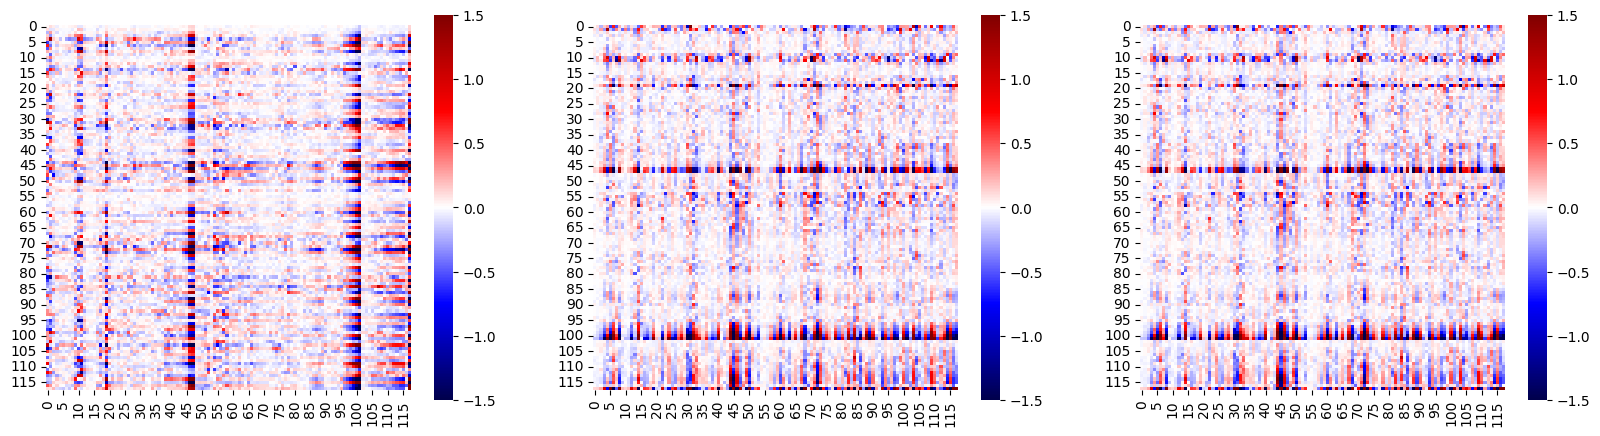

In [45]:
i = 0
A = copy.deepcopy(diffs[...,i])

jdiff = copy.deepcopy(diffs_julia[...,i])

d = diffs_julia[...,i].T
fig,ax = plt.subplots(1,3,figsize=(20,5))
ax = ax.flatten()
sns.heatmap(jdiff, cmap="seismic", center=0, square=True, vmax=1.5, vmin=-1.5, ax=ax[0])
sns.heatmap(d, cmap="seismic", center=0, square=True, vmax=1.5, vmin=-1.5, ax=ax[1])
sns.heatmap(A, cmap="seismic", center=0, square=True, vmax=1.5, vmin=-1.5, ax=ax[2])

print(np.allclose(A, d))

In [46]:

# Ensure the adjacency matrix is a NumPy array
abs_matrix = np.abs(np.array(copy.deepcopy(A)))

# Create a NetworkX graph from the adjacency matrix
G = nx.from_numpy_array(abs_matrix, create_using=nx.DiGraph)

# Get all edges with their absolute weights
edges = list(G.edges(data=True))
# Sort edges based on absolute weight
edges_sorted = sorted(edges, key=lambda x: abs(x[2]['weight']))


print(edges_sorted)

[(10, 75, {'weight': 3.347837871081616e-05}), (76, 40, {'weight': 5.1132320415231414e-05}), (76, 96, {'weight': 6.072470707378132e-05}), (30, 12, {'weight': 6.812052479726605e-05}), (57, 56, {'weight': 0.00010815104766935535}), (17, 95, {'weight': 0.00012123206067470721}), (32, 56, {'weight': 0.0001413490088403302}), (42, 54, {'weight': 0.00014338737472436094}), (97, 41, {'weight': 0.00016233178898603096}), (54, 114, {'weight': 0.0001850574553781681}), (37, 75, {'weight': 0.00019489370572595144}), (81, 107, {'weight': 0.0002338166622960422}), (82, 62, {'weight': 0.0002376197714795969}), (65, 36, {'weight': 0.0002446688533821878}), (48, 9, {'weight': 0.0002452669174674363}), (50, 1, {'weight': 0.00024992284870165374}), (95, 54, {'weight': 0.0002502001477009304}), (56, 116, {'weight': 0.0002542305220367136}), (71, 13, {'weight': 0.0002683711193142424}), (0, 37, {'weight': 0.0002726534549014059}), (77, 11, {'weight': 0.0002847429357933154}), (15, 74, {'weight': 0.00029361820851337567}), (

In [49]:
edges_sorted[19]

(0, 37, {'weight': 0.0002726534549014059})

In [51]:
result = drop_connections_until_split(A, remove_type='lowest', directed=True)

[(10, 75, {'weight': 3.347837871081616e-05}), (76, 40, {'weight': 5.1132320415231414e-05}), (76, 96, {'weight': 6.072470707378132e-05}), (30, 12, {'weight': 6.812052479726605e-05}), (57, 56, {'weight': 0.00010815104766935535}), (17, 95, {'weight': 0.00012123206067470721}), (32, 56, {'weight': 0.0001413490088403302}), (42, 54, {'weight': 0.00014338737472436094}), (97, 41, {'weight': 0.00016233178898603096}), (54, 114, {'weight': 0.0001850574553781681}), (37, 75, {'weight': 0.00019489370572595144}), (81, 107, {'weight': 0.0002338166622960422}), (82, 62, {'weight': 0.0002376197714795969}), (65, 36, {'weight': 0.0002446688533821878}), (48, 9, {'weight': 0.0002452669174674363}), (50, 1, {'weight': 0.00024992284870165374}), (95, 54, {'weight': 0.0002502001477009304}), (56, 116, {'weight': 0.0002542305220367136}), (71, 13, {'weight': 0.0002683711193142424}), (0, 37, {'weight': 0.0002726534549014059}), (77, 11, {'weight': 0.0002847429357933154}), (15, 74, {'weight': 0.00029361820851337567}), (

In [30]:
result.shape

(118, 118)

In [31]:
with h5py.File(jpath, "r") as f:
    julia_results = f['data']["results"][:]

In [32]:
julia_results.shape

(608, 118, 118)

False


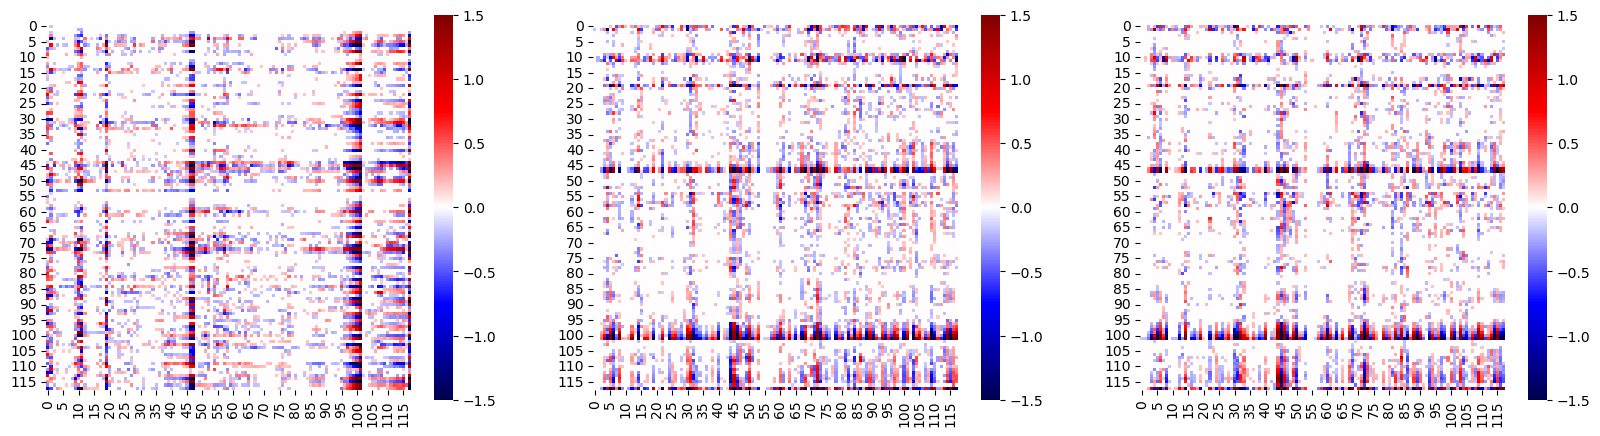

In [33]:
julia_result = julia_results[1,...]
# julia_result[30,:] = 1.5
julia_resultttttttttttt = copy.deepcopy(julia_result)

julia_result = julia_result.T
fig,ax = plt.subplots(1,3,figsize=(20,5))
ax = ax.flatten()
sns.heatmap(julia_resultttttttttttt, cmap="seismic", center=0, square=True, vmax=1.5, vmin=-1.5, ax=ax[0])
sns.heatmap(julia_result, cmap="seismic", center=0, square=True, vmax=1.5, vmin=-1.5, ax=ax[1])
sns.heatmap(result, cmap="seismic", center=0, square=True, vmax=1.5, vmin=-1.5, ax=ax[2])
print(np.allclose(julia_result, result))

In [15]:
A = diffs[...,0]
# Ensure the adjacency matrix is a NumPy array
abs_matrix = np.abs(np.array(A))

# Create a NetworkX graph from the adjacency matrix
G = nx.from_numpy_array(abs_matrix, create_using=nx.DiGraph)

# Get all edges with their absolute weights
edges = list(G.edges(data=True))
edges_sorted = sorted(edges, key=lambda x: abs(x[2]['weight']))

In [17]:
edges_sorted

[(101, 0, {'weight': 0.16447358862012434}),
 (77, 97, {'weight': 0.16449906487447388}),
 (84, 94, {'weight': 0.16455850183075757}),
 (11, 53, {'weight': 0.1645593071560471}),
 (12, 37, {'weight': 0.16459249250509833}),
 (110, 9, {'weight': 0.16465170403309745}),
 (49, 68, {'weight': 0.164683673917876}),
 (93, 72, {'weight': 0.1647217926993857}),
 (12, 26, {'weight': 0.16474002150731223}),
 (58, 64, {'weight': 0.1647565417068096}),
 (3, 47, {'weight': 0.1647836622673416}),
 (20, 83, {'weight': 0.16478593239568262}),
 (103, 68, {'weight': 0.16480871209687575}),
 (28, 99, {'weight': 0.16481318083387003}),
 (5, 102, {'weight': 0.16481679046662326}),
 (84, 49, {'weight': 0.16488669812288106}),
 (42, 3, {'weight': 0.16495402528309358}),
 (77, 101, {'weight': 0.16502511071208878}),
 (114, 35, {'weight': 0.16503271460930138}),
 (41, 90, {'weight': 0.16509931628276925}),
 (63, 3, {'weight': 0.16511685419019034}),
 (3, 12, {'weight': 0.16514829518714597}),
 (18, 112, {'weight': 0.165157671963335